# 1. Describe the data
- On January 8, 2008, US presidential primary elections were held in New Hampshire. Hillary Clinton unexpectedly defeated Barack Obama in the Democratic Party primary, despite pre-election opinion polls suggesting otherwise. Two different voting technologies were used: some districts used paper ballots counted by hand, while others used optically scanned ballots counted by machine. Obama received more votes than Clinton on the paper ballots, but Clinton won on the machine-counted ballots. This raised suspicions about the integrity of the election. The data used in this analysis was obtained from Herron et al. (2008).
- It has 276 observations (a precinct refers to a specific geographic area within New Hampshire used for electoral purposes. Each precinct represents a subdivision of the state where votes are collected and counted during elections)
- There are 12 variables:
    - votesys: voting system variable (D for digital or H for hand)
    - Obama: Number of votes received by Barack Obama.
    - Clinton: Number of votes received by Hillary Clinton.
    - dem: Number of registered Democrats in the precinct.
    - povrate: Poverty rate in the precinct.
    - pci: Per capita income in the precinct.
    - Dean: Proportion of votes received by Howard Dean.
    - Kerry: Proportion of votes received by John Kerry.
    - white: Percentage of white population in the precinct.
    - absentee: Number of absentee ballots. Absentee ballots are votes cast by voters who are unable or unwilling to attend the official polling station to which they are assigned on Election Day. These ballots are typically submitted by mail or through other means before the election.
    - population: Total population of the precinct.
    - pObama: Proportion of votes received by Barack Obama.

# 2. Load packages and data

In [127]:
%%capture
pip install faraway

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import faraway.utils
np.set_printoptions(suppress=True)

In [129]:
import faraway.datasets.newhamp
newhamp = faraway.datasets.newhamp.load()
newhamp.head()

,votesys,Obama,Clinton,dem,povrate,pci,Dean,Kerry,white,absentee,population,pObama
0,D,371,362,979,0.0653,25940,0.27820,0.32030,0.98312,0.059857,4693.0,0.378958
1,D,345,333,913,0.0380,19773,0.24398,0.36747,0.97349,0.050449,4266.0,0.377875
2,D,375,570,1305,0.0428,19986,0.20096,0.41627,0.96739,0.043649,7006.0,0.287356
3,H,92,89,268,0.0669,25627,0.28495,0.33333,0.97892,0.107356,1033.0,0.343284
4,D,668,595,1633,0.0332,32667,0.24937,0.37781,0.97986,0.074706,7033.0,0.409063


In [130]:
newhamp.groupby('votesys').agg({'Obama': 'sum', 'Clinton': 'sum'})

,Obama,Clinton
votesys,,
D,86353,96890
H,16926,14471


# 3. Linear regression
The author is interested in the proportion of votes for Obama in each ward, which is considered a response variable. Technically, this response variable follows a binomial distribution, but for large enough samples and probabilities that are not extremely close to zero or one, it can be approximated by a normal distribution. The variance of a binomial distribution is determined by the product of the probability of success (p) and the sample size (n), and in this example, both of these values vary. This violates the assumption of equal variance. This issue can be fixed by using weights, but for the purpose of the current discussion, it is being ignored.

In [131]:
# Create an indicator variable where 1 is hand and 0 is digital voting
newhamp['trt'] = np.where(newhamp.votesys == 'H', 1, 0)

In [132]:
# Run regression
lmodu = smf.ols('pObama ~ trt',newhamp).fit()
lmodu.sumary()

          coefs stderr tvalues pvalues
Intercept 0.353  0.005   68.15  0.0000
trt       0.042  0.009    4.99  0.0000

n=276 p=2 Residual SD=0.068 R-squared=0.08


- When digital voting is used, the predictor is set to 0 and the predicted proportion is therefore 35%. When hand voting is used, the prediction is $β_{trt}$ = 4% higher.
- The p-value of coefficient is very small, so the difference is significant. Obama received a significantly higher proportion of the vote in the hand voting wards. Why?

## 3.1. Confounding variable
- Suppose the model containing a further variable $y_i = β_0^* + β_1^*T_i + β_2^*Z_i + ε_i$ and $Z_i = γ_0 + γ_1T_i + \epsilon_i$ for T is an indicator variable of voting system.
- $Z_i$ is a confounding variable.
- The coefficient for T becomes $β_1^* + β_2^* γ_1$
    - If $β_2 = 0$, Z has no effect on the response variable.
    - If $γ_1 = 0$, T has no effect on Z.
    - Otherwise, Z will have an effect on our conclusions. In this case, the initial model that excludes Z will provide a biased estimate.
    - In a designed experiment, $γ_1$ is set to 0 through randomization in the assignment of T.
- We include the proportion of votes for Howard Dean.

In [170]:
lmodz = smf.ols('pObama ~ trt + Dean',newhamp).fit()
lmodz.sumary()

           coefs stderr tvalues pvalues
Intercept  0.221  0.011   19.65  0.0000
trt       -0.005  0.008   -0.61  0.5407
Dean       0.523  0.042   12.55  0.0000

n=276 p=3 Residual SD=0.054 R-squared=0.42


- Then the effect of the voting system T is no longer statistically significant.
- The proportion of votes for Howard Dean shows a significantly positive relationship to the proportion voting for Obama.

In [134]:
# Check the relationship between Dean and T
lmodc = smf.ols('Dean ~ trt',newhamp).fit()
lmodc.sumary()

          coefs stderr tvalues pvalues
Intercept 0.251  0.006   41.99  0.0000
trt       0.090  0.010    9.18  0.0000

n=276 p=2 Residual SD=0.079 R-squared=0.24


# 4. Matching
- For example, a clinical trial where they are comparing a new treatment to a control group. They have a group of subjects who have different characteristics such as sex, age, and overall health condition, which could potentially affect the outcome of the trial.
- Instead of randomly dividing the subjects into the treatment and control groups, it suggests a better approach called "matched pairs." In this approach, they try to find pairs of subjects who are as similar as possible in terms of their characteristics. For example, they would match a healthy older man with another healthy older man.
- Once the pairs are formed, the treatment and control groups are randomly assigned within each pair. By comparing the responses of the subjects within each pair, they can determine the effect of the treatment while considering the potential confounding factors. This approach helps to balance out the differences between the treatment and control groups and provides more reliable results.
- In the example of voting in New Hampshire, we can pose a hypothetical scenario where we have the opportunity to conduct an experiment in 2008 and assign different voting systems to different wards.
    - The procedure involves forming pairs of similar groups based on the proportion of people who previously supported Dean, a candidate. Within each pair, a random assignment is made.
    - In real life, it is not possible to make a random assignment. Instead, pairs of groups with similar proportions of Dean supporters can be identified, where one group uses hand voting, and the other group uses digital voting.
    - Since the variable "Dean" is continuous, exact matches are unlikely. We define an acceptable match using a "caliper" of 0.01 and employ a "greedy matching" algorithm. For each point in the smaller hand-voting group, we find a case in the digital-voting group with a Dean fraction within 0.01. Not all hand-voting cases will match due to the lack of close matches or already matched cases in the digital group.

In [135]:
# Define variables after grouping of voting system
sg = newhamp.Dean[newhamp.trt == 1] # Using hand
bg = newhamp.Dean[newhamp.trt == 0] # Using machine
sg.shape[0], bg.shape[0]

(102, 174)

In [136]:
# Create a place to store a match
ns = len(sg)
mp = np.full([ns,2],-1); mp[0:5]

array([[-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1]])

In [137]:
# Find and store matches
for i in range(ns):
    dist = abs(sg.iloc[i]-bg) # Find a difference between using hand and using machine
    if(dist.min() < 0.01):
        imin = dist.idxmin()
        mp[i,:] = [sg.index[i], imin] # Store index of sg in the left, and index of bg in the right
        bg = bg.drop(index = imin) # Remove the chosen index

In [138]:
sg.head()

3     0.28495
16    0.29927
17    0.30343
18    0.42742
20    0.25743
Name: Dean, dtype: float64

In [139]:
# Save the store place for available match
mp = mp[mp[:,0] > -1,:]; mp[:5]

array([[  3, 212],
       [ 16,  19],
       [ 17,   5],
       [ 18,  90],
       [ 20, 232]])

In [140]:
# Examin the first pair
newhamp.iloc[[3, 212],[0,6,11]]

,votesys,Dean,pObama
3,H,0.28495,0.343284
212,D,0.28457,0.382932


The value of Dean is very similar. The value of pObama is not much different.

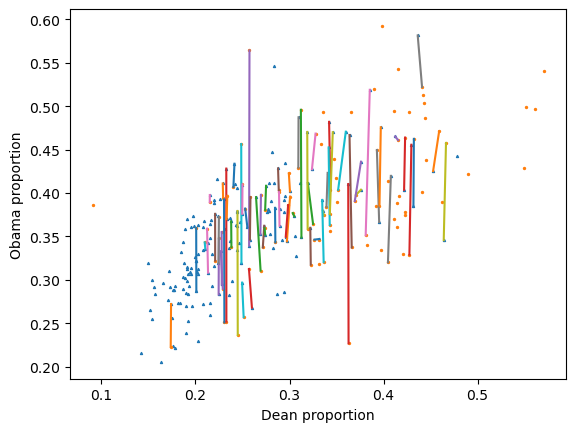

In [141]:
# Draw all possible matches
bg = newhamp.Dean[newhamp.trt == 0] # Using machine, rerun 'cause bg is already reduced by drop
sy = newhamp.pObama[newhamp.trt == 1] # Using hand
by = newhamp.pObama[newhamp.trt == 0] # Using machine
plt.scatter(bg, by, marker="^", s=2) # Machine Dean vs. machine Obama
plt.scatter(sg, sy, marker="o", s=2) # Hand Dean vs. hand Obama
plt.xlabel("Dean proportion"); plt.ylabel("Obama proportion")
for i in range(len(mp)): # len(mp) = 65
    dean_values = [newhamp.Dean.loc[mp[i, 0]], newhamp.Dean.loc[mp[i, 1]]]
    obama_values = [newhamp.pObama.loc[mp[i, 0]], newhamp.pObama.loc[mp[i, 1]]]
    plt.plot(dean_values, obama_values)

In [142]:
# Calculate difference between using hand and using machine in proportion of votes received by Obama
pdiff = sy.loc[mp[:,0]].to_numpy() - by.loc[mp[:,1]].to_numpy(); pdiff

array([-0.03964858,  0.02077306,  0.00371039, -0.12654645,  0.22477   ,
       -0.04236305,  0.03893508,  0.08294574,  0.11197574,  0.13675974,
        0.07743749, -0.09031997,  0.14711421, -0.07872877, -0.0041441 ,
       -0.12960523,  0.04100765, -0.09958583, -0.00525577,  0.00721492,
       -0.00072342, -0.01628898, -0.02981169,  0.06025294,  0.06041993,
        0.04885166, -0.16763599, -0.03909963, -0.00601097, -0.08930379,
       -0.14167714,  0.04576682, -0.04706637, -0.17633822,  0.06458616,
       -0.02487521, -0.00829393, -0.0593144 , -0.09411027, -0.06688842,
        0.07223272,  0.02692385,  0.00728007, -0.1835838 ,  0.04534029,
       -0.0250015 ,  0.03378563, -0.05795868, -0.14285714, -0.07163645,
       -0.02676765,  0.05153653, -0.02764201,  0.03653589, -0.04312977,
       -0.05385452,  0.05054818,  0.05301917, -0.11142899, -0.03974876,
        0.02142836, -0.04928663, -0.08461953,  0.04454105, -0.04531334])

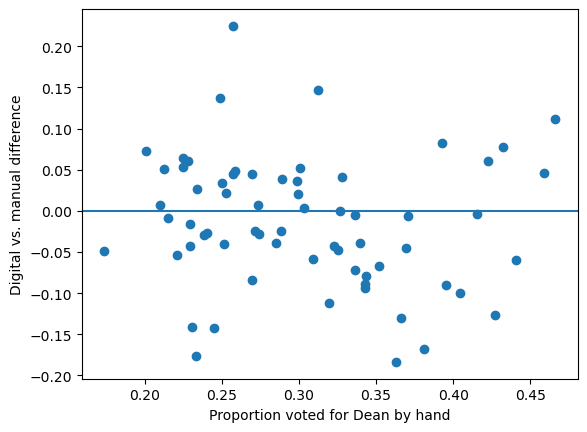

In [143]:
# Show the matched pair differences
plt.scatter(sg.loc[mp[:,0]], pdiff)
plt.axhline(0)
plt.xlabel('Proportion voted for Dean by hand'); plt.ylabel('Digital vs. manual difference');

In [144]:
# Perform sample t-test
sp.stats.ttest_1samp(pdiff, 0)

TtestResult(statistic=-1.4443435651040761, pvalue=0.15352040145988724, df=64)

- We see that the differences are not statistically significant different from zero. Furthermore, the difference doesn’t appear to depend on the Dean vote.
- The author found a way to compare two different voting methods by matching wards with similar political views.
    - One ward used digital voting, while the other used a manual method.
    - After comparing the two voting methods, the author concluded that there was no significant difference between them.
    - The observed difference in the results was due to the fact that voters who preferred Obama were more likely to be present in wards that used the manual voting method.

# 5. Covariate Adjustment

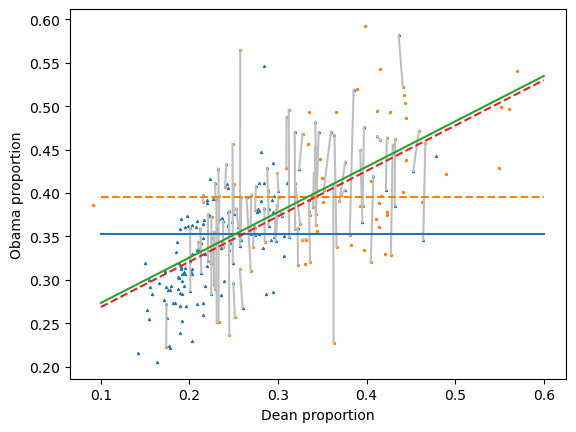

In [154]:
plt.scatter(bg, by, marker="^", s=2)
plt.scatter(sg, sy, marker="o", s=2)
plt.xlabel("Dean proportion")
plt.ylabel("Obama proportion")
for i in range(len(mp)):
    dean_values = [newhamp.Dean.loc[mp[i, 0]], newhamp.Dean.loc[mp[i, 1]]]
    obama_values = [newhamp.pObama.loc[mp[i, 0]], newhamp.pObama.loc[mp[i, 1]]]
    plt.plot(dean_values, obama_values, color="0.75")
drange = [0.1,0.6]
x0 = pd.DataFrame({"trt": (0,0), "Dean": drange})
x1 = pd.DataFrame({"trt": (1,1), "Dean": drange})
plt.plot(drange,lmodu.predict(x0)) # Horizontal for machine voting in Obama
plt.plot(drange,lmodu.predict(x1), linestyle="dashed") # Horizontal for hand voting in Obama
plt.plot(drange,lmodz.predict(x0)) # Regression line for machine voting in Obama
plt.plot(drange,lmodz.predict(x1), linestyle="dashed"); # Regression line for hand voting in Obama

- The two horizontal lines correspond to the unadjusted model with the solid line for digital and dashed line for manual. Obama does better on the manual voting machines. 
- If we consider the expected response for a fixed value of Dean, the difference between digital and hand is given by the vertical distance between the two sloped lines.
- Each pair represents a local realization of that vertical difference. When we average these pairwise differences, we also estimate the vertical difference.

In [159]:
# Average the pairwise differences
oba_diff = []
for i in range(len(mp)):
    khacbiet = abs(newhamp.pObama.loc[mp[i, 0]] - newhamp.pObama.loc[mp[i, 1]])
    oba_diff.append(khacbiet)
np.mean(oba_diff)

0.06403320291174519

In [171]:
# Difference between two slopes of two regression lines
lmodz.params['trt']

-0.004753780938822137

- Matching on a covariate (like Dean) and fitting a linear model are two different ways to estimate the same thing.
- The "covariate adjustment" method, sometimes called "controlling for a covariate", is easier 
to use and extends well to multiple confounders. But it requires us to specify how the factor affects the model in the right way. In simpler terms, we need to understand how the factor behaves in order to use it correctly. For example, we need to specify the functional form of the covariate in the model in an appropriate way.
- The matching approach is more robust in that because it doesn't require us to specify how the factor affects the model. Instead, it focuses on finding pairs of observations that are similar in terms of the factor being studied. This method works well when there is a lot of overlap between the two groups being compared.
- The covariate adjustment method is commonly used because it is easier, but the matching approach can also provide valuable insights in certain situations.

# 6. Quantitative support for causation
- In observational studies, there are limitations to what can be accomplished through statistical manipulations. In Hill (1965), Hill outlined several factors that can strengthen the argument for a causal relationship between two variables.
- "Strength" refers to the magnitude or size of a particular variable's effect on an outcome. When assessing the strength of a variable's effect, it is not just about looking at statistical measures like correlation or p-values. Instead, it is important to consider the practical significance of the estimated coefficient $\hat{β}$ .We need to account for known covariates (other variables that may influence the outcome) in order to get a more accurate understanding of the variable's strength. However, it cautions that there may be unobserved or unexpected confounding variables that could lead to small effects, making it harder to determine the true strength of the variable. It is less believable that a previously unknown variable could counteract a large effect. In other words, if a variable's effect is already substantial, it is unlikely that an unknown factor would completely negate or reverse that effect.
- The concept of consistency in scientific research. When similar effects are observed in different subjects, in different circumstances, at different times and places, it strengthens the evidence for a particular claim. For example, if both male and female smokers from Argentina and Sweden, both currently and in the past, tend to develop lung cancer, it provides stronger evidence that smoking is a cause of lung cancer. Replication by independent research groups is crucial in establishing causation. This means that when multiple research teams conduct the same study and obtain similar results, it adds further credibility to the findings.
- The concept of specificity. Specificity refers to a situation where a certain cause is closely associated with a particular effect and not with a variety of other possible effects. For example, imagine there is a lung disease that is only found in workers from a specific industry. If this disease is not commonly found in workers from other industries and those workers do not experience other health issues more frequently than workers in other industries, then the case for the specific cause of the disease becomes stronger. In simpler terms, specificity means that when a particular cause is closely linked to a specific effect and not to a wide range of other effects, it provides stronger evidence for the relationship between the cause and the effect.
- The concept of "temporality" in relation to cause and effect. Temporality refers to the idea that the cause of an event or outcome is determined or fixed before the event or outcome actually happens. In other words, there is a clear sequence of events where the cause comes before the effect. However, sometimes it can be difficult to determine whether one event causes another or if it's the other way around. In these cases, it can be helpful to establish the direction of the effect by looking at the order in which the events occur. If event X happens before event Y, it suggests that X may be the cause of Y.
- Gradient. The response to a supposed causal variable increases or decreases consistently as that variable increases. In simpler terms, it means that as you do more of something, the outcome or effect becomes either better or worse. However, there is an exception to this rule called "hormesis." For example, in the case of alcohol consumption, a low consumption of alcohol may have some health benefits compared to not drinking at all. But if you drink too much alcohol, it becomes increasingly harmful to your health. In general, the gradient concept suggests that the more you do something, the more pronounced the effect becomes. But there can be exceptions like hormesis, where the relationship between the variable and its effect is not strictly linear.
- Plausibility. If there is a theory that has a credible explanation or evidence to suggest that it has a cause-and-effect relationship, the observational study might be conducted as part of an effort to provide further support for this theory.
- A natural experiment occurs when subjects are assigned different values of a variable in a seemingly random way. For example, different US states may have different laws that affect a specific factor. This can be seen as a form of random assignment. Observational studies are often conducted because conducting actual experiments is not always feasible. However, in some cases, related experiments can still be done. For instance, experiments conducted on animals can provide insights into the effects of certain factors on humans. Overall, natural experiments can provide valuable information in situations where conducting controlled experiments is not possible.
- Even if not all of the ideas mentioned are applicable, there might still be a cause-and-effect relationship between them. Or even though all the ideas are applicable, we cannot be sure if they are directly causing something. Despite the uncertainty of causation, these ideas still contribute to the overall evidence. Even though we cannot measure the effect of these ideas in a numerical way, they still provide valuable information and strengthen the evidence.